In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
#@title Utilities

import kornia
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import PIL
import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import Image, HTML, clear_output, display
from ipywidgets import Output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

clear_output()

In [3]:
torch.__version__, kornia.__version__

('1.6.0', '0.5.11')

## Utils

In [59]:
def load_image(url, max_size=100):
    r = requests.get(url)
    img = PIL.Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
    img_np = np.float32(img)/255.0
    # premultiply RGB by Alpha
    img_np[..., :3] *= img_np[..., 3:]
    return img_np, img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
    return load_image(url)


def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.2)
    plt.show()

    
def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img


class VideoWriter:
    def __init__(self, filename, fps=30.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)

    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1)*255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()


class EasyTensor:
    def __init__(self, tensor):
        self.raw = tensor

    def sq(self, dim=0):
        return EasyTensor(self.raw.squeeze(dim=dim))

    def usq(self, dim=0):
        return EasyTensor(self.raw.unsqueeze(dim=dim))

    @property
    def chw(self):
        return EasyTensor(self.raw.permute(0, 3, 1, 2))

    @property
    def chw(self):
        return EasyTensor(self.raw.permute(0, 3, 1, 2))

    @property
    def hwc(self):
        return EasyTensor(self.raw.permute(0, 2, 3, 1))

    @property
    def np(self):
        return self.raw.detach().cpu().numpy()

    def imshow(self):
        plt.imshow(self.np)


torch.Tensor.ez: EasyTensor = property(lambda self: EasyTensor(self))

## Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


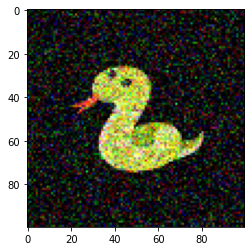

In [123]:
noise = nn.Sequential(
    kornia.augmentation.RandomAffine(
        degrees=20,
        translate=[0.2, 0.2],
        scale=[0.9, 1.1],
        shear=[-10, 10],
    ),
    kornia.augmentation.RandomPerspective(0.6, p=1.0),
    kornia.augmentation.RandomGaussianNoise(mean=0.0, std=0.20, p=1),
)

img_np, img_pil = load_emoji('🐍')
img_ez_tensor = torch.tensor(img_np).ez.usq().chw.raw
x = torch.cat([img_ez_tensor, torch.rand(1, 10, 100, 100)], dim=1)
noise(x)[:,:].ez.hwc.raw[0,:,:,:3].ez.imshow()

## Models

In [76]:
class CAEncoder(nn.Module):
    def __init__(self, num_chanels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=num_chanels, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=num_chanels, kernel_size=(1, 1), stride=1, padding=0),
            nn.Tanh(),
        )


        # self.net[0].weight.data.normal_()
        self.net[0].bias.data.zero_()
        # self.net[2].weight.data.normal_()
        self.net[2].bias.data.zero_()
        # self.net[4].weight.data.normal_()
        self.net[4].bias.data.zero_()

    def forward(self, x, steps):
        for i in range(steps):
            x = x + self.net(x)
#         image_out = torch.sigmoid(x[:,:3]) * 3
#         state_out = torch.tanh(x[:,3:])
#         state_out = x[:,3:]
#         x = torch.cat([image_out, state_out], dim=1)
        return x


class Decoder(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(512, output_size),
        )

    def forward(self, x):
        return self.net(x)

xe = torch.rand(2, 16, 100, 100)
xd = torch.rand(2, 3, 32, 32)

encoder = CAEncoder(num_chanels=16)
decoder = Decoder(output_size=32)

encoder(xe, steps=4).shape, decoder(xd).shape

(torch.Size([2, 16, 100, 100]), torch.Size([2, 32]))

In [131]:
class NoisyChannel(nn.Module):
    def __init__(self, msg_size, seed_shape, encoder, decoder, noise):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.noise = noise

        self.msg_size = msg_size
        self.seed_shape = seed_shape
        self.optim = torch.optim.Adam([*self.encoder.parameters(), *self.decoder.parameters()], lr=0.001)
    
    @property
    def device(self):
        return next(iter(self.parameters())).device

    def generate_msg(self, bs):
        return torch.rand(bs, self.msg_size, device=self.device)

    def generate_seeded_input(self, bs):
        msg = self.generate_msg(bs)
        c, h, w = self.seed_shape
        x = torch.zeros(*[bs, *self.seed_shape], device=self.device)
        mid_w, mid_h = w // 2, h // 2
        x[:, -self.msg_size:, mid_h, mid_w] = msg
        return x, msg
    
    def step(self, x):
        return self.encoder(x, steps=1)

    def forward(self, bs, steps):
        input, msg = self.generate_seeded_input(bs)
        x = self.encoder(input, steps // 2)
        first_x = x
        noisy_x = self.noise(x)
        x = self.encoder(x, steps // 2)
        return first_x, x

    def training_step(self, bs, steps):
        self.optim.zero_grad()

        input, msg = self.generate_seeded_input(bs)
        x = self.encoder(input, steps // 2)
        first_x = x
        noisy_x = self.noise(x)
        x = self.encoder(noisy_x, steps // 2)
        msg_pred = self.decoder(x[:,:3])
        first_msg_pred = self.decoder(first_x[:,:3])
        
        loss = F.mse_loss(msg_pred, msg)
        loss += F.mse_loss(first_msg_pred, msg)
        loss.backward()
        self.optim.step()

        return loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


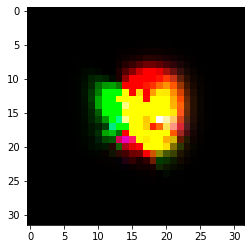

In [132]:
#@title Setup {vertical-output: true}

msg_size = 32
ca_depth = 32

encoder = CAEncoder(num_chanels=ca_depth)
decoder = Decoder(output_size=msg_size)

noisy_channel = NoisyChannel(
    msg_size=msg_size,
    seed_shape=[ca_depth, 32, 32],
    encoder=encoder,
    decoder=decoder,
    noise=noise
).to('cuda')

log_loss = []

first_x, last_x = noisy_channel.forward(bs=1, steps=100)
imgs = first_x.ez.hwc.np
plt.imshow(imgs[0,:,:,:3])

In [ ]:
#@title Training {vertical-output: true}

out = Output()
display(out)

tq = tqdm(range(10001))

for i in tq:
    steps = 15 + i // 30
    loss = noisy_channel.training_step(bs=32, steps=steps)
    log_loss.append(loss)
    tq.set_description(f'Loss: {loss:.6f}')

    with out:
        if i % 50 == 0:
            clear_output(wait=True)
            plot_loss(log_loss)
            plt.show()

            first_x, last_x = noisy_channel.forward(bs=1, steps=steps)
            imgs = first_x.ez.hwc.np
            plt.imshow(imgs[0, :, :, :3])
            plt.show()
            torch.save(noisy_channel, 'model.pk')

Output()

In [ ]:
# torch.save(noisy_channel, 'model.pk')
noisy_channel = torch.load('model.pk')

In [ ]:
x, _ = noisy_channel.generate_seeded_input(bs=1)

with VideoWriter('test.mp4') as vid:
    for i in range(300):
        x = noisy_channel.step(x)
        frame = x.ez.hwc.raw[0,:,:,:3].ez.np
        vid.add(zoom(frame, scale=8) * 0.5 + 0.5)

        
nonce = np.random.rand()
display(
  HTML(
  f"""
      <video controls autoplay loop>
            <source src="test.mp4#{nonce}" type="video/mp4">
      </video>
  """
       )   
)